In [2]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

import requests
import time
import re    

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options

import os

pd.set_option('display.max_columns', None)
%matplotlib inline

### Scraping The Numbers for movie 1 and movie 2 of a franchise

In [4]:
# Ping Movie Franchise page and scrape info if responsive
response = requests.get("http://www.the-numbers.com/movies/franchises/sort/No")
if response.status_code == 200:
    soup = BeautifulSoup(response.text, "lxml")
else:
    print('Bad response; status_code: %d' %response.status_code)

In [13]:
# Find the table
franchise_table = soup.find_all("table")
franchises = franchise_table[0]

In [35]:
# Pull links from the table
franchise_link = []
first = True
for row in franchises.findAll("tr"):
    link = row.find("a")
    if first:
        first = False
    else:
        if int(link.next_element.next_element.next_element.text) > 1:
            franchise_link.append(link["href"])

In [37]:
response = requests.get('http://www.the-numbers.com/movies/franchise/Barbie')

In [38]:
soup = BeautifulSoup(response.text, "lxml")

In [39]:
movie_franchise_table_all = soup.find_all("table")

In [43]:
movie_franchise_table = movie_franchise_table_all[0]

In [ ]:
movie_franchise_data = []
for row in movie_franchise_table("tr"):
    row_dict={}
    for i,cell in enumerate(row.findAll("td")):
        row_dict[header[i]] = cell.find(text=True)
        link = row.find("a")
        if link:
            row_dict['Title'] = link.text
            row_dict['Link'] = link["href"]
    movie_franchise_data.append(row_dict) 

In [226]:
# initialize storage dfs and header
header = ['Year','Title']
original_films = pd.DataFrame(columns = header)
sequel_films = pd.DataFrame(columns = header)

# Ping each franchise page and scrape table if responsive
for franchise in franchise_link:
    currlink = 'http://www.the-numbers.com' + franchise
    response = requests.get(currlink)
    
    # ping and soupify if responsive
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "lxml")
    else:
        print('Bad response; status_code: %d' %response.status_code) 
    
    # find the table
    movie_franchise_table_all = soup.find_all("table")
    movie_franchise_table = movie_franchise_table_all[0]
    
    # scrape table data
    movie_franchise_data = []
    first = True
    for row in movie_franchise_table("tr"):
        if first:
            first = False
        else:
            row_dict={}
            table_row = row.findAll("td")
            for i in [0,1]:
#                 print('a' + table_row[0].text+ 'b')
                if not(table_row[0].text.strip()== ''):
                    row_dict['Year'] = (table_row[0].text)[-4:]
                    row_dict['Title'] = (table_row[1].find('a')).text
                movie_franchise_data.append(row_dict) 
        
    # convert to a df and make dates a datetime object
    movie_franchise_df = pd.DataFrame(movie_franchise_data)
    movie_franchise_df['Year']=pd.to_datetime(movie_franchise_df['Year'], errors='coerce')
    sorted_by_date_franchise = movie_franchise_df.sort_values('Year')
    sorted_by_date_franchise = sorted_by_date_franchise.drop_duplicates()
   
    # interested in storing only the two oldest films (i.e. film 1 and its sequel)
    if sorted_by_date_franchise.iloc[1].Year.year < 2017:
        original_films = original_films.append(sorted_by_date_franchise.iloc[0], ignore_index=True)
        sequel_films = sequel_films.append(sorted_by_date_franchise.iloc[1], ignore_index=True)
    
    # log file to keep track of scraping progress
    with open('ErrorLog.txt','a') as efile:
        efile.write('\nFinished movie link: {}'.format(currlink))
   

In [227]:
# Delete entries that only had statistics for only one movie (sequels to be released soon)
original_films_clean = original_films[~sequel_films['Year'].isnull()]
sequel_films_clean = sequel_films[~sequel_films['Year'].isnull()]

In [232]:
original_films_clean.set_value(18, 'Title','Planet of the Apes') 

,Year,Title
0,2002-01-01,Barbie as Rapunzel
1,1963-01-01,Dr. No
2,2008-01-01,Iron Man
3,1989-01-01,Batman
4,1999-01-01,Pokemon: The First Movie
5,1979-01-01,Star Trek: The Motion Picture
6,1977-01-01,Star Wars Ep. IV: A New Hope
7,1980-01-01,Friday the 13th
8,1978-01-01,National Lampoon's Animal House
9,2001-01-01,Harry Potter and the Sorcererâs Stone


In [318]:
sequel_films_clean.set_value(372, 'Title','2010') 

,Year,Title
0,2006-01-01,Barbie Fairytopia: Mermaidia
1,1964-01-01,From Russia With Love
2,2008-01-01,The Incredible Hulk
3,1992-01-01,Batman Returns
4,2000-01-01,Pokemon 2000
5,1982-01-01,Star Trek II: The Wrath of Khan
6,1980-01-01,Star Wars Ep. V: The Empire Strikes Back
7,1981-01-01,Friday the 13th Part 2
8,1982-01-01,National Lampoon's Class Reunion
9,2002-01-01,Harry Potter and the Chamber of Secrets


### Scraping IMDB for budget, genre, and ratings

In [106]:
chromedriver = "./chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)
driver.get("http://www.imdb.com")


In [115]:
conversion_df = pd.read_csv('conversion_table',index_col='Year')

In [337]:
movie_data = []
headers = ['movie title', 'budget','imbd rating', 'genre', 'director', 'stars']

# chop = webdriver.ChromeOptions()
# chop.add_extension('Adblock-Plus_v1.4.1.crx')
# driver = webdriver.Chrome(chrome_options = chop)

def do_movie_search(driver, chromedriver):
#        driver.find_element_by_id("navbar-query").clear()
        try:
            navbar =driver.find_element_by_id("navbar-query").clear()
        except:
            driver.close()
            driver = webdriver.Chrome(chromedriver)
            driver.get("http://www.imdb.com") 
        driver.find_element_by_id("navbar-query").clear()
        query = driver.find_element_by_id("navbar-query")
        search_input = original_films_clean.iloc[i].Title.encode('utf-8').strip()
        query.send_keys(search_input)
        query.send_keys(Keys.RETURN)
        div = driver.find_element_by_class_name('findTitleSubfilterList')
        div.find_element_by_css_selector('a').click()
        
        
def selenium_scrape_imdb(original_films_clean):
    
#     chromedriver = "/Users/lilliantong/ds/metis/sf17_ds5/local/projects/02-luther/chromedriver"
    chop = webdriver.ChromeOptions()
    chop.add_extension('Adblock-Plus-Pro_v1.4.0.crx')
#     os.environ["webdriver.chrome.driver"] = chromedriver
    driver = webdriver.Chrome(executable_path="/Users/lilliantong/ds/metis/sf17_ds5/local/projects/02-luther/chromedriver", chrome_options = chop)
     
#     driver = webdriver.Chrome(chromedriver)
    driver.get("http://www.imdb.com")
#     for i in [456]:
#     for i in range(11):
    for i in range(495, len(original_films_clean.Title)):
#     for i in range(len(original_films_clean.Title)):
        # get the search bar
        query = driver.find_element_by_id("navbar-query")
        # search by move title plus the year it was made
        movie_year = original_films_clean.iloc[i].Year.year
        movie_title = unicode(original_films_clean.iloc[i].Title.encode('utf-8'), errors='ignore')
        search_input = movie_title + ' (' + str(movie_year) + ')'
        query.send_keys(search_input)
        query.send_keys(Keys.RETURN)

        div = driver.find_element_by_class_name('findTitleSubfilterList')
        div.find_element_by_css_selector('a').click()
        
        # if no results were found, take out the year and search again
        src = driver.page_source
        no_results_found = re.search(r'No results found', src)
        
        if no_results_found:
            do_movie_search(driver, chromedriver)
        
        # if no image for the top result (implying obscure movie), take out the year and search again
        div_pic = driver.find_element_by_class_name('primary_photo')
        pic = div_pic.find_element_by_css_selector('img')
        no_pic_found = re.search(r'nopicture', pic.get_attribute('src'))
        
        if no_pic_found:
            do_movie_search(driver, chromedriver)
        
        # if no results were found again, then give up
        src = driver.page_source
        no_results_found = re.search(r'No results found', src)
        
        if no_results_found:
            movie_dict = dict(zip(headers, [original_films_clean.iloc[i].Title,
                                  np.nan,
                                  np.nan,
                                np.nan,
                                np.nan,
                                np.nan]))
        else:
            div2 = driver.find_element_by_class_name('result_text')
            div2.find_element_by_css_selector('a').click()

            # soup the page
            soup_page = BeautifulSoup(driver.page_source)

            # get budget or set to NaN if not there
            budget_pre= soup_page.find(text ="Budget:")

            if budget_pre:
                budget = budget_pre.next.strip()
                budget = budget.replace('$','')
                budget = budget.replace(',','')
                if budget.isdigit():
                    if movie_year < 1934 and movie_year > 1929:
                        budget_adjusted = float(budget) / 0.35 * conversion_df.loc[2017].Value
                    elif movie_year < 1929 and movie_year > 1924:
                        budget_adjusted = float(budget) / 0.25 * conversion_df.loc[2017].Value
                    elif movie_year < 1924 and movie_year > 1910:
                        budget_adjusted = float(budget) / 0.07 * conversion_df.loc[2017].Value
                    else:
                        if movie_year == 1960:
                            movie_year = 1961
                        elif movie_year == 1950:
                            movie_year = 1949
                        elif movie_year == 1952:
                            movie_year = 1951
                        elif movie_year > 1945 and movie_year <1948:
                            movie_year = 1945
                        
                        budget_adjusted = float(budget) / conversion_df.loc[movie_year].Value * conversion_df.loc[2017].Value
                else:
                    budget_adjusted = '*' + budget
            else:
                budget_adjusted = np.nan

            #get imdb rating
            rating_html = soup_page.find("div", { "class" : "ratingValue" })
            if rating_html:
                rating_all = rating_html.text.strip()
                rating = float(rating_all.split('/')[0])
            else:
                rating = np.nan

            # get genre
            genre_html = soup_page.find("div", { "class" : "subtext" })
            subtext_array= genre_html.text.split('|')
            if len(subtext_array)< 3:
                genre_list = np.nan
            else:
                genre_list = subtext_array[2].split(',')
                genre_list = list(map(lambda x: x.replace("\n",""), genre_list))

            # get director
            director_div = soup_page.find("div", { "class" : "credit_summary_item" })
            director_array = re.split("[\n',]", director_div.text)
            director_array = [x.strip() for x in director_array]
            director_array= filter(None, director_array)
            director_array = [w.replace(' (uncredited)', '') for w in director_array]
            director = director_array[1:]

            # get stars
            stars_html = soup_page.find(text ="Stars:")
            if stars_html:
                a = stars_html.findNext('span').findNext('span')
                b = a.findNext('span').findNext('span')
                c = b.findNext('span').findNext('span')
                stars = [a.text, b.text, c.text]
            else:
                stars = np.nan

            movie_dict = dict(zip(headers, [original_films_clean.iloc[i].Title,
                                        budget_adjusted,
                                        rating,
                                        genre_list,
                                        director,
                                        stars]))
        print(i)
        print(movie_dict)
        movie_data.append(movie_dict)
#         csv_df = pd.DataFrame.from_dict({k : pd.Series(v) for k, v in movie_dict.iteritems()})
#         with open('test.csv', 'a') as f:
#             csv_df.to_csv(f, header=False)
    
    driver.close()  
    return movie_data


In [252]:
#number_original1 = selenium_scrape_imdb(original_films_clean) # 0-399 KEEP

0
{'director': [u'Terence Young'], 'budget': 1637693.6316695355, 'imbd rating': 7.3, 'movie title': u'Barbie as Rapunzel', 'stars': [u'Sean Connery', u'Ursula Andress', u'Bernard Lee'], 'genre': [u'Action', u' Adventure', u' Thriller']}
1
{'director': [u'Jerry Lewis'], 'budget': nan, 'imbd rating': 6.7, 'movie title': u'Dr. No', 'stars': [u'Jerry Lewis', u'Stella Stevens', u'Del Moore'], 'genre': [u'Comedy', u' Romance', u' Sci-Fi']}
2
{'director': [u'Jon Favreau'], 'budget': 168662952.64623958, 'imbd rating': 7.9, 'movie title': u'Iron Man', 'stars': [u'Robert Downey Jr.', u'Gwyneth Paltrow', u'Terrence Howard'], 'genre': [u'Action', u' Adventure', u' Sci-Fi']}
3
{'director': [u'Tim Burton'], 'budget': 76259445.843828723, 'imbd rating': 7.6, 'movie title': u'Batman', 'stars': [u'Michael Keaton', u'Jack Nicholson', u'Kim Basinger'], 'genre': [u'Action', u' Adventure']}
4
{'director': [u'Terence Young'], 'budget': 1873031.4960629921, 'imbd rating': 7.3, 'movie title': u'Pokemon: The Fir

In [263]:
#number_original2 = selenium_scrape_imdb(original_films_clean) # 400: KEEP

400
{'director': [u'Kirk Jones'], 'budget': 33015267.175572522, 'imbd rating': 6.6, 'movie title': u'Nanny McPhee', 'stars': [u'Emma Thompson', u'Colin Firth', u'Angela Lansbury'], 'genre': [u'Comedy', u' Family', u' Fantasy']}
401
{'director': [u'Brian De Palma'], 'budget': 55306905.370843984, 'imbd rating': 7.9, 'movie title': u'The Untouchables', 'stars': [u'Kevin Costner', u'Sean Connery', u'Robert De Niro'], 'genre': [u'Crime', u' Drama', u' Thriller']}
402
{'director': [u'Scott Derrickson'], 'budget': 3260050.2512562815, 'imbd rating': 6.8, 'movie title': u'Sinister', 'stars': [u'Ethan Hawke', u'Juliet Rylance', u'James Ransone'], 'genre': [u'Horror', u' Mystery']}
403
{'director': [u'Ruben Fleischer'], 'budget': 27218666.666666668, 'imbd rating': 7.7, 'movie title': u'Zombieland', 'stars': [u'Jesse Eisenberg', u'Emma Stone', u'Woody Harrelson'], 'genre': [u'Adventure', u' Comedy', u' Horror']}
404
{'director': [u'Howard Zieff'], 'budget': 34928741.092636585, 'imbd rating': 6.8, 

In [272]:
#number_sequel1 = selenium_scrape_imdb(sequel_films_clean) # 0-10 KEEP

0
{'director': [u'Terence Young'], 'budget': 1452671.755725191, 'imbd rating': 7.3, 'movie title': u'Barbie Fairytopia: Mermaidia', 'stars': [u'Sean Connery', u'Ursula Andress', u'Bernard Lee'], 'genre': [u'Action', u' Adventure', u' Thriller']}
1
{'director': [u'Terence Young'], 'budget': 18602150.53763441, 'imbd rating': 7.5, 'movie title': u'From Russia With Love', 'stars': [u'Sean Connery', u'Robert Shaw', u'Lotte Lenya'], 'genre': [u'Action', u' Adventure', u' Thriller']}
2
{'director': [u'Louis Leterrier'], 'budget': 180710306.40668526, 'imbd rating': 6.8, 'movie title': u'The Incredible Hulk', 'stars': [u'Edward Norton', u'Liv Tyler', u'Tim Roth'], 'genre': [u'Action', u' Adventure', u' Sci-Fi']}
3
{'director': [u'Tim Burton'], 'budget': 166746987.95180723, 'imbd rating': 7.0, 'movie title': u'Batman Returns', 'stars': [u'Michael Keaton', u'Danny DeVito', u'Michelle Pfeiffer'], 'genre': [u'Action']}
4
{'director': [u'Michael Haigney', u'Kunihiko Yuyama'], 'budget': 48144712.4304

In [284]:
#number_sequel2 = selenium_scrape_imdb(sequel_films_clean) # 12:282 KEEP

12
{'director': [u'Rick Rosenthal'], 'budget': 7778776.9784172671, 'imbd rating': 6.6, 'movie title': u'Halloween II', 'stars': [u'Jamie Lee Curtis', u'Donald Pleasence', u'Charles Cyphers'], 'genre': [u'Horror']}
13
{'director': [u'Blake Edwards'], 'budget': nan, 'imbd rating': 7.6, 'movie title': u'A Shot in the Dark', 'stars': [u'Peter Sellers', u'Elke Sommer', u'George Sanders'], 'genre': [u'Comedy', u' Crime', u' Mystery']}
14
{'director': [u'Richard Martin'], 'budget': nan, 'imbd rating': 4.4, 'movie title': u'Air Bud: Golden Receiver', 'stars': [u'Kevin Zegers', u'Cynthia Stevenson', u'Tim Conway'], 'genre': [u'Comedy', u' Family', u' Sport']}
15
{'director': [u'Borja Cobeaga', u'Javier Fesser', u'|', u'3 more credits\xa0\xbb'], 'budget': nan, 'imbd rating': 8.1, 'movie title': u'2006 Academy Award Nominated Short Films', 'stars': [u'Ram\xf3n Barea', u'Mariv\xed Bilbao', u'Robb Buckland'], 'genre': nan}
16
{'director': [u'Kazuki Ohmori'], 'budget': 10894206.549118388, 'imbd rati

In [336]:
# number_sequel3 = selenium_scrape_imdb(sequel_films_clean) # 284:499 KEEP

284
{'director': [u'Dan Scanlon'], 'budget': 212792127.92127919, 'imbd rating': 7.3, 'movie title': u'Monsters University', 'stars': [u'Billy Crystal', u'John Goodman', u'Steve Buscemi'], 'genre': [u'Animation', u' Adventure', u' Comedy']}
285
{'director': [u'James Bobin'], 'budget': 170000000.0, 'imbd rating': 6.3, 'movie title': u'Alice Through the Looking Glass', 'stars': [u'Mia Wasikowska', u'Johnny Depp', u'Helena Bonham Carter'], 'genre': [u'Adventure', u' Family', u' Fantasy']}
286
{'director': [u'Guy Ritchie'], 'budget': 136349306.43127367, 'imbd rating': 7.5, 'movie title': u'Sherlock Holmes: A Game of Shadows', 'stars': [u'Robert Downey Jr.', u'Jude Law', u'Jared Harris'], 'genre': [u'Action', u' Adventure', u' Crime']}
287
{'director': [u'Tom Shadyac'], 'budget': 220021802.32558143, 'imbd rating': 5.4, 'movie title': u'Evan Almighty', 'stars': [u'Steve Carell', u'Morgan Freeman', u'Lauren Graham'], 'genre': [u'Comedy', u' Family', u' Fantasy']}
288
{'director': [u'Noam Murro

In [338]:
# number_sequel4 = selenium_scrape_imdb(sequel_films_clean) # 495:

495
{'director': [u'Terence Young'], 'budget': 1128706.9988137605, 'imbd rating': 7.3, 'movie title': u'Tremors 5: Bloodlines', 'stars': [u'Sean Connery', u'Ursula Andress', u'Bernard Lee'], 'genre': [u'Action', u' Adventure', u' Thriller']}
496
{'director': [u'Terence Young'], 'budget': 1164626.6829865361, 'imbd rating': 7.3, 'movie title': u'Wolf Creek 2', 'stars': [u'Sean Connery', u'Ursula Andress', u'Bernard Lee'], 'genre': [u'Action', u' Adventure', u' Thriller']}
497
{'director': [u'Terence Young'], 'budget': 1268666.6666666667, 'imbd rating': 7.3, 'movie title': u'Still Waiting...', 'stars': [u'Sean Connery', u'Ursula Andress', u'Bernard Lee'], 'genre': [u'Action', u' Adventure', u' Thriller']}
498
{'director': [u'Steven E. Gordon (as Steve Gordon)', u'Boyd Kirkland'], 'budget': nan, 'imbd rating': 3.9, 'movie title': u"Happily N'Ever After 2: Snow White", 'stars': [u'G.K. Bowes', u'Kelly Brewster', u'Doug Erholtz'], 'genre': [u'2 October 2009 (Italy) ']}
499
{'director': [u'Al

In [401]:
movie_dict_batsup = dict(zip(headers, [sequel_films_clean.iloc[11].Title,
                                        float(250000000) / conversion_df.loc[2016].Value * conversion_df.loc[2017].Value,
                                        6.7,
                                        ['Action', 'Adventure', 'Sci-Fi'],
                                        ['Zack Snyder'],
                                        ['Ben Affleck', 'Henry Cavill', 'Amy Adams']]))

In [402]:
movie_dict_dory= dict(zip(headers, [sequel_films_clean.iloc[283].Title,
                                        float(200000000) / conversion_df.loc[2016].Value * conversion_df.loc[2017].Value,
                                        7.5,
                                        ['Animation', 'Adventure', 'Comedy'],
                                        [ 'Andrew Stanton', 'Angus MacLane'],
                                        ['Ellen DeGeneres', 'Albert Brooks', 'Ed O Neill']]))

In [403]:
number_original = number_original1 + number_original2

In [404]:
number_sequel1.append(movie_dict_batsup)
number_sequel2.append(movie_dict_dory)

In [406]:
number_sequel = number_sequel1 + number_sequel2 + number_sequel3 + number_sequel4[5:]

In [407]:
len(number_original)

628

### Cleaning up the data to match

In [408]:
# Convert scraped data to dfs
full_original_movie_dfn = pd.DataFrame(number_original)
full_sequel_movie_dfn = pd.DataFrame(number_sequel)

In [409]:
# Merge the data from movie dojo and IMDB
original_merged = full_original_movie_dfn.merge(original_films_clean, left_on='movie title', right_on = 'Title')
sequel_merged = full_sequel_movie_dfn.merge(sequel_films_clean, left_on='movie title', right_on = 'Title')

In [410]:
original_merged_dup_drop = original_merged.drop_duplicates(['Title', 'budget'])
sequel_merged_dup_drop = sequel_merged.drop_duplicates(['Title', 'budget'])

In [532]:
# drop the movies that have N/A budgets from both tables
dropna_budget_mask = original_merged_dup_drop.budget.isnull() | sequel_merged_dup_drop.budget.isnull()
original_movie_budgetna = original_merged_dup_drop[~dropna_budget_mask]
sequel_movies_budgetna = sequel_merged_dup_drop[~dropna_budget_mask]

In [533]:
len(original_movie_budgetna)

452

In [534]:
# drop movies with N/A star from both tables
stars_mask = sequel_movies_budgetna.stars.isnull()
original_movie_budgetna = original_movie_budgetna[~stars_mask]
sequel_movies_budgetna = sequel_movies_budgetna[~stars_mask]

In [535]:
# drop movies with foreign budgets from both dfs
foreign_budget_mask = (original_movie_budgetna.budget.map(lambda x: type(x)) == unicode) | (sequel_movies_budgetna.budget.map(lambda x: type(x)) == unicode)
original_movie_budgetna = original_movie_budgetna[~foreign_budget_mask]
sequel_movies_budgetna = sequel_movies_budgetna[~foreign_budget_mask]


In [536]:
# Strip genre elements
original_movie_budgetna.genre=original_movie_budgetna.genre.map(lambda x: [y.strip() for y in x])

In [537]:
# Make boolean table for genre categories
genre=pd.get_dummies(original_movie_budgetna.genre.apply(pd.Series).stack()).sum(level=0)

In [538]:
# drop movies with wrong genres
bad_genre_mask = (genre.ix[:, 0] == 1) | (genre.ix[:, 1] == 1) | (genre.ix[:, 2] == 1)
original_movie_budgetna = original_movie_budgetna[~bad_genre_mask]
sequel_movies_budgetna = sequel_movies_budgetna[~bad_genre_mask]
genre = genre[~bad_genre_mask]

In [794]:
# drop "Terrance Young director, crazy duplicates:
terrance_mask = (sequel_movies_budgetna.director.str[0] == 'Terence Young') | (original_movie_budgetna.director.str[0] == 'Terence Young')
original_movie_budgetna = original_movie_budgetna[~terrance_mask]
sequel_movies_budgetna = sequel_movies_budgetna[~terrance_mask]
genre = genre[~terrance_mask]

In [795]:
len(original_movie_budgetna)

306

In [797]:
len(genre)

306

### Make feature df

In [798]:
# Create a feature df
featuredfn = pd.DataFrame(columns = ['movie-1', 'movie-2', 'time', 'budget-ratio', 'movie-1-rating', 'same-lead', 'same-director'])

In [799]:
# Time between release of movie 2 and movie 2
time_between = (sequel_movies_budgetna['Year'] - original_movie_budgetna['Year'])
time_between = (time_between / np.timedelta64(1, 'D')).astype(int)

In [800]:
# Budget of movie 2 / Budget of movie 1
budget_ratio = sequel_movies_budgetna.budget.div(original_movie_budgetna.budget)

In [801]:
star_in_sequel = [s1 in s2 for s1, s2 in zip(original_movie_budgetna.stars.str[0], sequel_movies_budgetna.stars)]

In [802]:
same_director = [s1 in s2 for s1, s2 in zip(original_movie_budgetna.director.str[0], sequel_movies_budgetna.director)]

In [803]:
# Fill in the columns
featuredfn['movie-1'] = original_movie_budgetna.Title
featuredfn['movie-2'] = sequel_movies_budgetna.Title
featuredfn['time'] = time_between
featuredfn['budget-ratio'] = budget_ratio
featuredfn['movie-1-rating'] = original_movie_budgetna['imbd rating']
featuredfn['same-lead'] = star_in_sequel
featuredfn['same-director'] = same_director

In [804]:
features = featuredfn.loc[:, ['time', 'budget-ratio', 'movie-1-rating', 'same-lead', 'same-director']]

In [805]:
all_features = pd.concat([features, genre.ix[:,3:]], axis=1)

In [806]:
y = sequel_movies_budgetna['imbd rating']

In [807]:
len(sequel_movies_budgetna)

306

### Check features

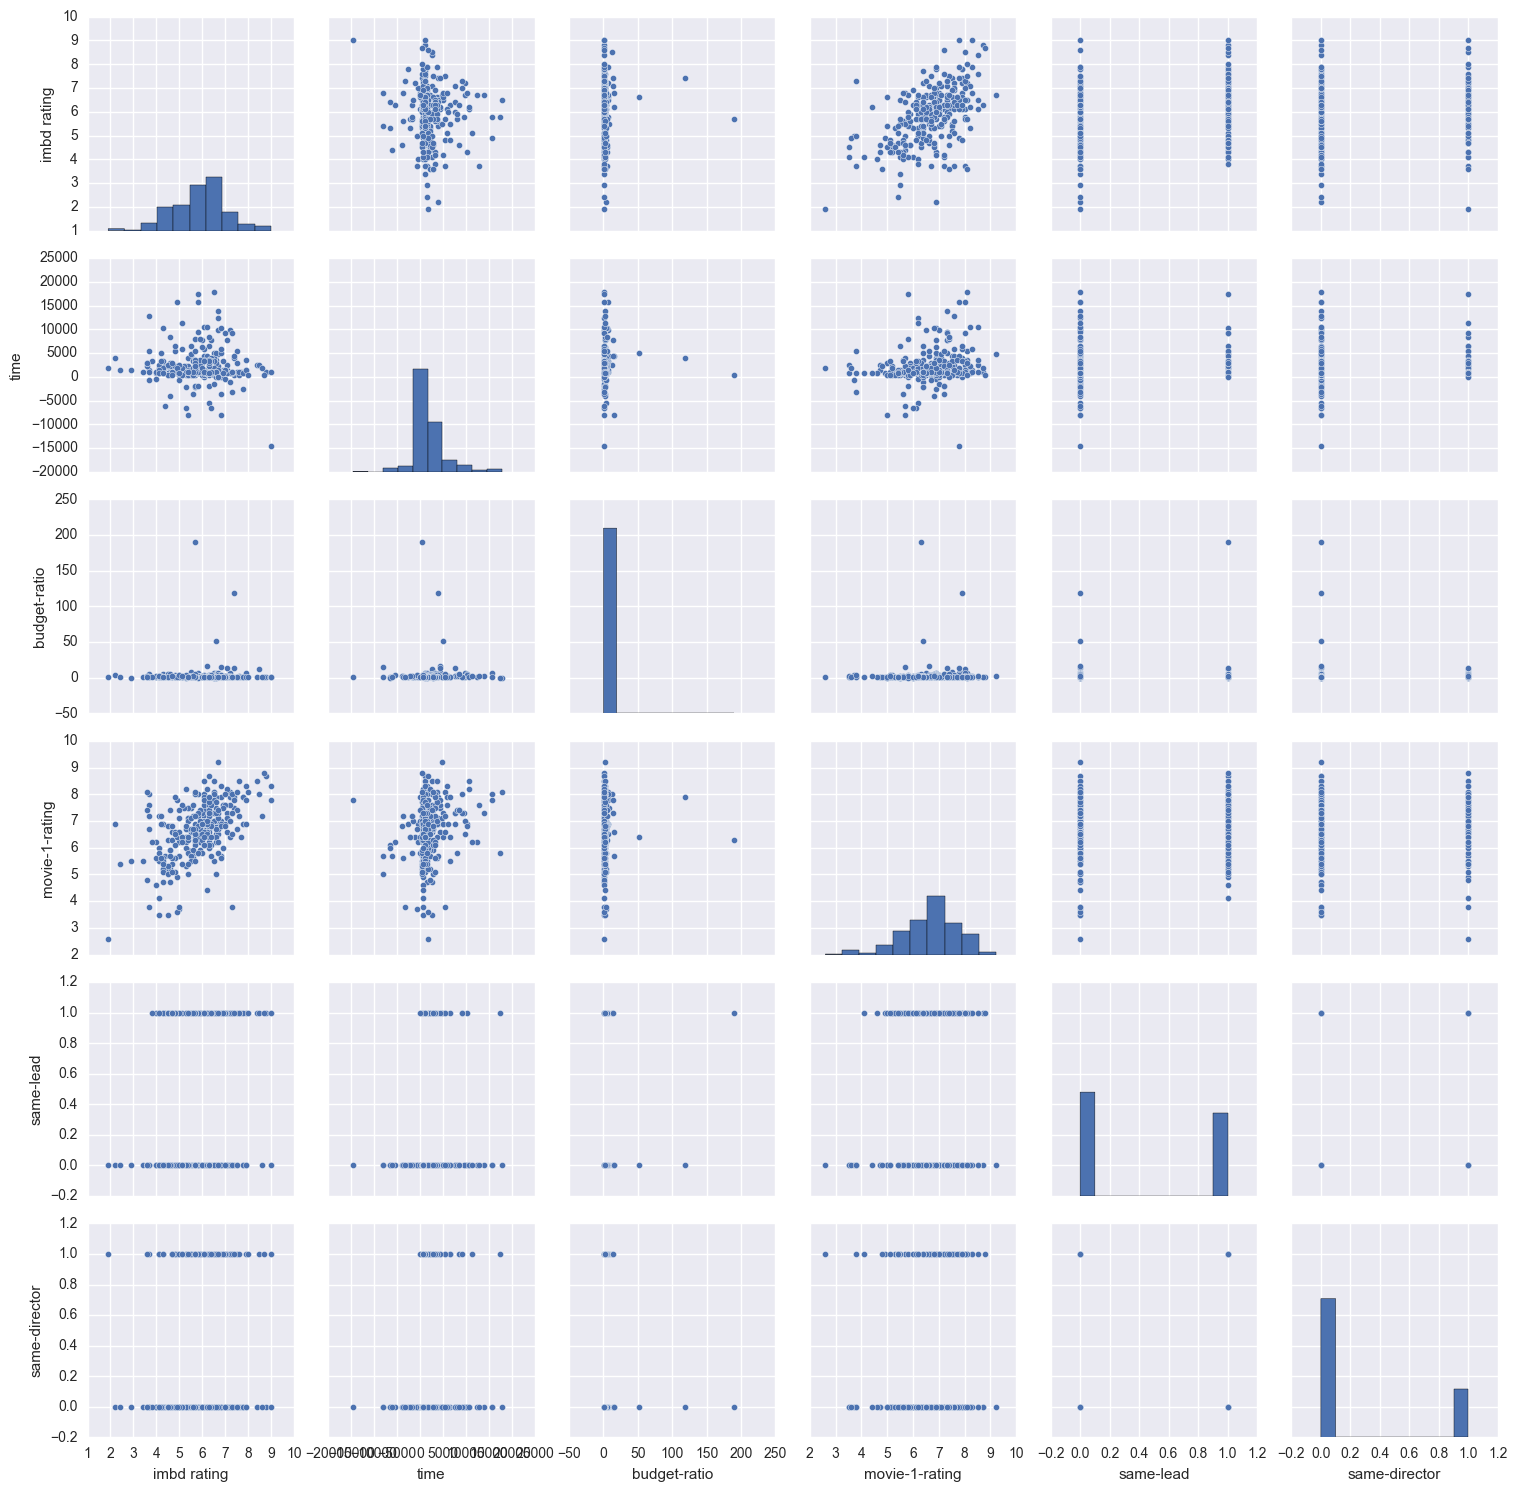

In [995]:
pairplot = pd.concat([y, features], axis=1)
sns.pairplot(pairplot)

In [810]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics


In [984]:
X_train, X_test, y_train, y_test = train_test_split(all_features, y, test_size=0.25)

### Linear Regression

In [822]:
lr_model1 = LinearRegression()
lr_model1_fit = lr_model1.fit(X_train, y_train)
lr1_pred = lr_model1.predict(X_test)
lr1_train_pred = lr_model1.predict(X_train)

In [823]:
lr_model1.score(X_train, y_train)

0.40018381525345803

In [824]:
lr_model1.score(X_test, y_test)

0.28278287124314017

In [825]:
metrics.mean_squared_error(y_test, lr1_pred)

1.1381216076178682

In [1038]:
X = all_features.loc[:,'movie-1-rating'].values

In [1039]:
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, test_size=0.25)

In [1040]:
lr_model2 = LinearRegression()
lr_model2_fit = lr_model2.fit(X_train, y_train)
lr1_pred2 = lr_model2.predict(X_test)
lr1_train_pred2 = lr_model2.predict(X_train)

In [1041]:
lr_model2.score(X_test, y_test)

0.40916305846637524

In [1042]:
metrics.mean_squared_error(y_test, lr1_pred2)

0.76910646783626124

### Random Forest

In [826]:
rfmodel1 = RandomForestRegressor(n_estimators = 500, min_samples_leaf=5, n_jobs=-1, max_features = 20) 
rfmodel1_fit = rfmodel1.fit(X_train, y_train)
rf1_pred = rfmodel1.predict(X_test)
rf1_train_pred = rfmodel1.predict(X_train)

In [827]:
rfmodel1.score(X_train, y_train)

0.61993703163526792

In [828]:
rfmodel1.score(X_test, y_test)

0.35651212637547014

In [829]:
metrics.mean_squared_error(y_test, rf1_pred)

1.0211237627321499

### Gradient Boosted

In [985]:
# gbmodel1 = GradientBoostingRegressor(n_estimators=500, max_features = 23, learning_rate = 0.015, max_depth = 3, min_samples_leaf=15)
gbmodel1 = GradientBoostingRegressor(n_estimators=500, max_features = 10, learning_rate = 0.01, max_depth = 3, min_samples_leaf=1)
gbmodel1_fit = gbmodel1.fit(X_train, y_train)
gb1_pred = gbmodel1.predict(X_test)
gb1_train_pred = gbmodel1.predict(X_train)

In [955]:
min_samples_leaf_range = range(20,30)
max_features_range = range(13, len(all_features.columns)-3)
max_depth_range = range(2,5)
learning_rate_range = np.linspace(0.01, 0.05, 5)

In [956]:
param_grid_gb = dict(max_depth= max_depth_range, min_samples_leaf =min_samples_leaf_range, max_features= max_features_range, learning_rate=learning_rate_range)

In [986]:
grid_gb = GridSearchCV(gbmodel1, param_grid_gb, cv=5, scoring='mean_squared_error')

In [958]:
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.015,
             loss='ls', max_depth=3, max_features=23, max_leaf_nodes=None,
             min_samples_leaf=15, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [13, 14, 15, 16, 17, 18, 19, 20], 'learning_rate': array([ 0.01,  0.02,  0.03,  0.04,  0.05]), 'max_depth': [2, 3, 4], 'min_samples_leaf': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [959]:
print(grid_gb.best_score_)
print(grid_gb.best_params_) 

-0.892517415882
{'max_features': 20, 'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 21}


In [987]:
gbmodel1.score(X_train, y_train)

0.66120521608131444

In [988]:
gbmodel1.score(X_test, y_test)

0.38709908522239223

In [989]:
metrics.mean_squared_error(y_test, gb1_pred)

0.66876183505548326

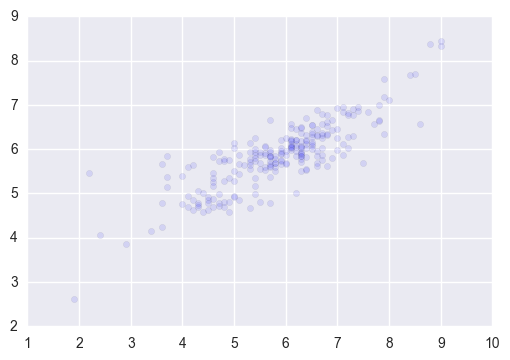

In [990]:
# Plot training results
plt.scatter(y_train, gb1_train_pred, alpha=0.1)

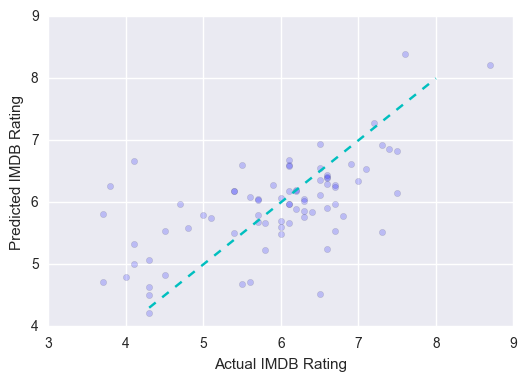

In [1000]:
# Plot test prediction results
plt.scatter(y_test, gb1_pred, alpha=0.2)
plt.plot(np.linspace(4.3,8,1000),np.linspace(4.3,8,1000), '--', color='c')
plt.ylabel('Predicted IMDB Rating')
plt.xlabel('Actual IMDB Rating')
# plt.xlim(3,9)
# plt.ylim(3,9)

(array([  3.,   1.,  13.,  38.,  42.,  75.,  87.,  30.,  10.,   7.]),
 array([ 1.9 ,  2.61,  3.32,  4.03,  4.74,  5.45,  6.16,  6.87,  7.58,
         8.29,  9.  ]),
 <a list of 10 Patch objects>)

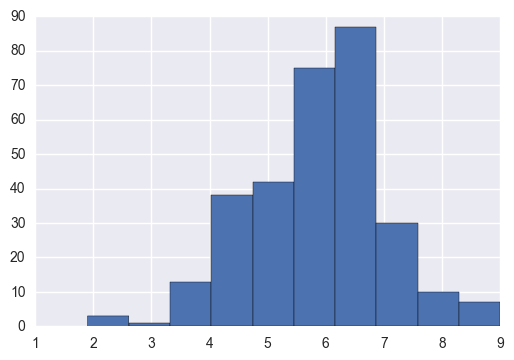

In [928]:
# Look at distribution of Sequel IMDB ratings
plt.hist(y)